In [1]:
import cv2
import numpy as np
import sys
import os 
from pdf2image import convert_from_path
import easyocr
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

In [2]:
# pdf 路徑
pdf_path = "..\\..\\data\\pdf\\BoredPile\\plan_all.pdf"
# csv 路徑
csv_path = "plan.csv"
# 輸出路徑
output_path = "result.xml"

### 第一階段用ocr抓型號、樁徑

* pdf 轉 png

True

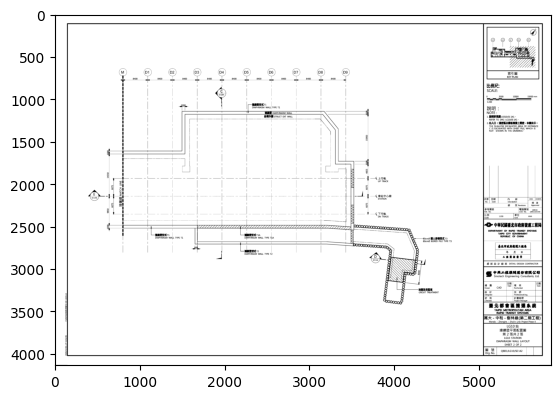

In [19]:
images = convert_from_path(pdf_path, dpi =500, poppler_path = r'C:\\Users\\jimmy\Downloads\\Release-24.02.0-0\\poppler-24.02.0\\Library\\bin')

cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)

# ROTATE_90_COUNTERCLOCKWISE
cv2_img = cv2.rotate(cv2_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)
plt.imshow(img_blur, cmap='gray')

* easyocr

In [20]:
reader = easyocr.Reader(['en'])
bounds = reader.readtext(img_blur, detail=1)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


* 篩選關鍵字，獲得型號

In [22]:
response = []
for word in bounds:
    if word[1].find("BORED PILE") > -1:
        print(word[1])
        response.append(word[1])



8Ocm@ BORED PILE TYPE T3


### 第二階段用 csv 抓繫樑行進米、排樁根數、樁徑

In [3]:
csv_data = pd.read_csv(csv_path)

# Extract the coordinates
coordinates = csv_data[['位置 X', '位置 Y']].values

# Calculate the pairwise distances
distances = cdist(coordinates, coordinates, metric='euclidean')

# Initialize the path and visited nodes
n_points = len(coordinates)
visited = np.zeros(n_points, dtype=bool)
path = [0]  # Start from the first point
visited[0] = True

# Greedy algorithm to find the nearest neighbor path
for _ in range(1, n_points):
    last_point = path[-1]
    nearest_neighbor = np.argmin(distances[last_point, ~visited])
    next_point = np.where(~visited)[0][nearest_neighbor]
    path.append(next_point)
    visited[next_point] = True

# Add the first point at the end to complete the loop
path.append(path[0])

# Calculate the total length of the path
total_length = sum(
    np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]])
    for i in range(n_points) if np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]]) <= 4
)

print(f'The total number of bordpile is {n_points}')
print(f'The total length of the path is {total_length:.2f}')


The total number of bordpile is 104
The total length of the path is 82.29


#### 成果視覺化